# Imports

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load Kaggle Data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=aabb8654eae694450fdd46a36555e01fcf9db8979f81c9a189f162f09ea7fc68
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
base_dir = 'drive/MyDrive/Documents/Project/ECE228'

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"

100% 6.31G/6.31G [01:33<00:00, 52.1MB/s]
100% 6.31G/6.31G [01:36<00:00, 70.5MB/s]


In [ ]:
import subprocess
subprocess.call(['unzip', '{}/histopathologic-cancer-detection.zip'.format(base_dir)])

0

# Tensorflow Transfer learning

---



## Sans Augmentation

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
data_generator = ImageDataGenerator(validation_split=0.2)

In [ ]:
train_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                         target_size=IMG_SIZE,
                                                         class_mode='binary', 
                                                         subset='training', 
                                                         batch_size=BATCH_SIZE)

Found 176021 images belonging to 2 classes.


In [ ]:
validation_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                              target_size=IMG_SIZE,
                                                              class_mode='binary', 
                                                              subset='validation', 
                                                              batch_size=BATCH_SIZE)

Found 44004 images belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 30

In [ ]:
history = model.fit(train_data_iterator, epochs=initial_epochs, validation_data=validation_data_iterator, verbose=True)

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model0_30.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model0_30.h5'))

### Plot loss and accuracy

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=(initial_epochs - 1),#history.epoch[-1], 
                         validation_data=validation_data_iterator)

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

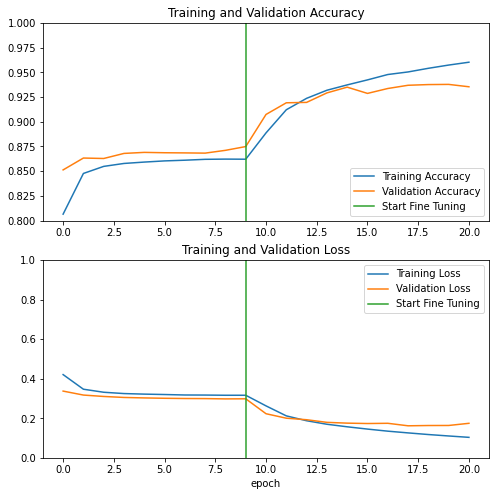

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_tuned_30.h5'))

In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_tuned.h5'))

### Confusion Matrix

In [ ]:
sample, labels = validation_data_iterator.next()
predictions = model.predict(sample)
batches = 1
for x, y in validation_data_iterator:
  predictions = np.append(predictions, model.predict(x), axis=0)
  labels = np.append(labels, y)
  batches = batches + 1
  if batches >= STEP_SIZE_VALIDATION:
    break

In [ ]:
predictions[predictions < 0] = 0
predictions[predictions > 0] = 1

In [ ]:
y_true = labels
y_pred = predictions 

In [ ]:
roc_auc_score(y_true, y_pred)

0.9321633149850984

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[25376   816]
 [ 1855 15893]]


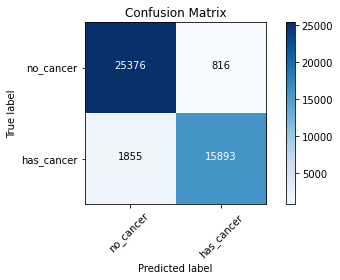

In [ ]:
cm_plot_labels = ['no_cancer', 'has_cancer']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
f1_score(y_true, y_pred)

0.9229435227469797

## Data Augmentation (with image generation)

### Generate additional images

In [ ]:
aug = ImageDataGenerator(brightness_range=[0.3, 1], 
                         horizontal_flip=True, 
                         vertical_flip=True, 
                         channel_shift_range=150)

In [ ]:
folders = ['train']#, 'test']
labels = ['0', '1']
# provide degree of data expansion required, 1x, 2x, 1.5x, 0.5x
p = 1.5 #not used currently due to uncertain behaviour of imagedatagenerator

In [ ]:
for folder in folders:
    df = pd.read_csv('{}_labels.csv'.format(folder))
    for filename, label in zip(df['id'], df['label']):
        image = tf.keras.preprocessing.image.load_img('{}/{}/{}/{}.tif'.format('dataset_folder', folder, label, filename))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = np.expand_dims(image, axis=0)
        for x, var in zip(aug.flow(image, batch_size=1, save_to_dir='{}/{}/{}/'.format('dataset_folder', folder, label), save_prefix='aug_{}'.format(filename), save_format='tif'), range(0)):
            pass
        #imageGen = aug.flow(image, batch_size=1, save_to_dir='{}/{}/{}/'.format('test_folder', folder, label), save_prefix='aug_{}'.format(filename), save_format='tif')

        """for itr in range(int(p)):
          next(imageGen)"""
        """
        if random.random() < (p -  int(p)):
          next(imageGen)
        """

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
data_generator = ImageDataGenerator(validation_split=0.2)

In [ ]:
train_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                         target_size=IMG_SIZE,
                                                         class_mode='binary', 
                                                         subset='training', 
                                                         batch_size=BATCH_SIZE)

Found 176021 images belonging to 2 classes.


In [ ]:
validation_data_iterator = data_generator.flow_from_directory('{}/{}'.format(new_base_dir, 'train'), 
                                                              target_size=IMG_SIZE,
                                                              class_mode='binary', 
                                                              subset='validation', 
                                                              batch_size=BATCH_SIZE)

Found 44004 images belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 10

In [ ]:
history = model.fit(train_data_iterator, epochs=initial_epochs, validation_data=validation_data_iterator, verbose=True)

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen.h5'))

### Plot loss and accuracy

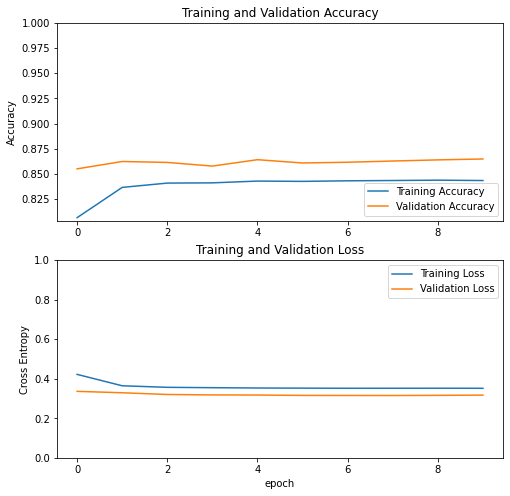

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1], 
                         validation_data=validation_data_iterator)

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

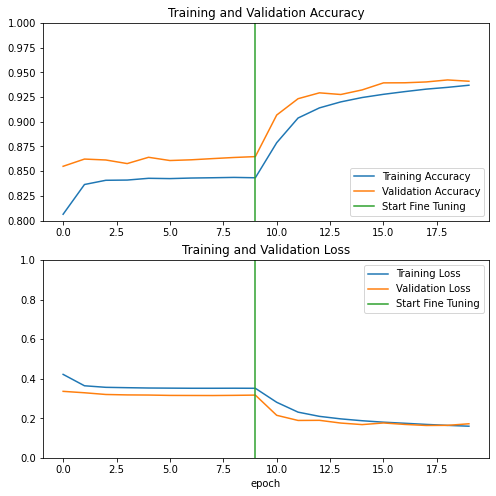

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen_tuned.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_dataGen_tuned.h5'))

### Confusion Matrix

In [ ]:
sample, labels = validation_data_iterator.next()
predictions = model.predict(sample)
batches = 1
for x, y in validation_data_iterator:
  predictions = np.append(predictions, model.predict(x), axis=0)
  labels = np.append(labels, y)
  batches = batches + 1
  if batches >= STEP_SIZE_VALIDATION:
    break

In [ ]:
predictions[predictions < 0] = 0
predictions[predictions > 0] = 1

In [ ]:
y_true = labels
y_pred = predictions 

In [ ]:
roc_auc_score(y_true, y_pred)

0.9366879296958311

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[24373  1823]
 [ 1012 16732]]


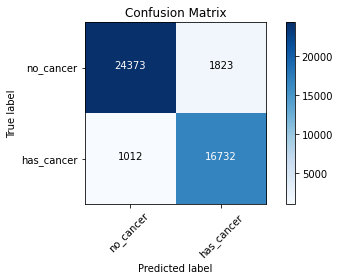

In [ ]:
cm_plot_labels = ['no_cancer', 'has_cancer']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
f1_score(y_true, y_pred)

0.9219316558619932

## Data Augmentation (with replacement) 30

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
def add_noise_rotate(img_array):
    noise = np.random.randint(-5,6, img_array.shape)
    noise = noise 
    img = img_array + noise
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

In [ ]:
train_csv = 'train_labels.csv'
test_csv = 'sample_submission.csv'

traindf=pd.read_csv(train_csv,dtype=str)
testdf=pd.read_csv(test_csv,dtype=str)

def append_ext(fn):
    return fn+".tif"

traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)


train_df,val_df1=train_test_split(traindf,test_size=0.3,random_state=42,stratify=traindf['label'])
val_df,test_df=train_test_split(val_df1,test_size=0.33,random_state=42,stratify=val_df1['label'])

In [ ]:
data_generator = ImageDataGenerator(brightness_range=[0.3, 1], 
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    preprocessing_function=add_noise_rotate)
data_generator_noaug = ImageDataGenerator()

In [ ]:
train_data_iterator=data_generator.flow_from_dataframe(dataframe=train_df,
                                                 directory='train',
                                                 x_col="id",
                                                 y_col="label",
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=False,
                                                 class_mode="binary",
                                                 target_size=IMG_SIZE)

validation_data_iterator=data_generator.flow_from_dataframe(dataframe=val_df,
                                                      directory='train',
                                                      x_col="id",
                                                      y_col="label",
                                                      batch_size=BATCH_SIZE,
                                                      seed=42,
                                                      shuffle=False,
                                                      class_mode="binary",
                                                      target_size=IMG_SIZE)

test_data_iterator = data_generator_noaug.flow_from_dataframe(dataframe=test_df,
                                                         directory='train',
                                                         x_col="id",
                                                         y_col="label",
                                                         batch_size=1,
                                                         seed=42,
                                                         shuffle=False,
                                                         class_mode="binary",
                                                         target_size=IMG_SIZE)

Found 154017 validated image filenames belonging to 2 classes.
Found 44225 validated image filenames belonging to 2 classes.
Found 21783 validated image filenames belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size
STEP_SIZE_test = test_data_iterator.n//test_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

### Train Model

In [ ]:
initial_epochs = 30

In [ ]:
filepath = '{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug_30.h5')
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_data_iterator, 
                    epochs=initial_epochs, 
                    validation_data=validation_data_iterator,
                    verbose=True,
                    callbacks=callbacks_list)

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug_30.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plot loss and accuracy

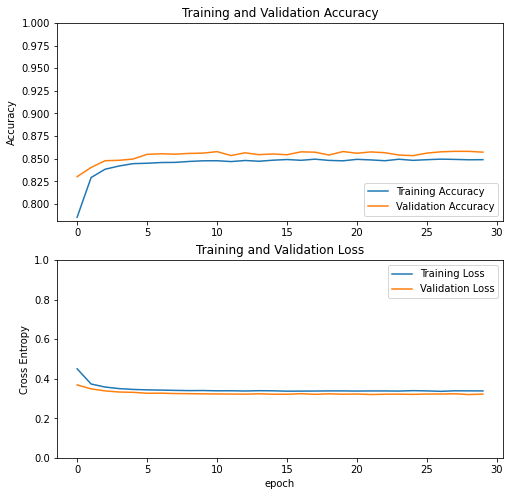

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:
filepath = '{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug_tuned_30.h5')
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks_list = [checkpoint]

In [ ]:
history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=59,#history.epoch[-1], 
                         validation_data=validation_data_iterator, 
                         verbose=True, 
                         callbacks=callbacks_list)

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

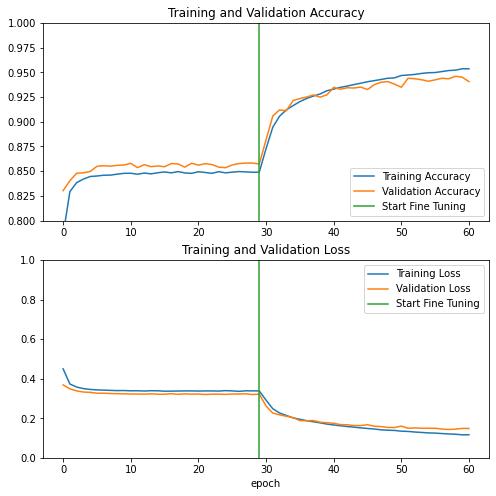

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug_tuned_30.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_dataAug_tuned_30.h5'))

### Confusion Matrix

In [ ]:
# make a prediction
def predict_on_test(model, test_gen, df_size):
    predictions1 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions1, predictions1 >= 0, 1)    
    np.putmask(predictions1, predictions1 < 0, 0)
    
    predictions2 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions2, predictions2 >= 0, 1)
    np.putmask(predictions2, predictions2 < 0, 0)

    predictions3 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions3, predictions3 >= 0, 1)
    np.putmask(predictions3, predictions3 < 0, 0)
    
    predictions4 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions4, predictions4 >= 0, 1)
    np.putmask(predictions4, predictions4 < 0, 0)
    
    predictions5 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions5, predictions5 >= 0, 1)
    np.putmask(predictions5, predictions5 < 0, 0)
    
    predictions = predictions1 + predictions2 + predictions3 + predictions4 + predictions5
    np.putmask(predictions, predictions >= 3, 1)
    np.putmask(predictions, predictions < 3, 0)
    predictions = predictions.flatten()
    df_preds = pd.DataFrame(predictions, columns=['has_tumor_tissue'])

    y_true = test_gen.classes
    y_pred = df_preds['has_tumor_tissue']

    print("F1 Score: " + str(sklearn.metrics.f1_score(y_true, y_pred)))
    print("AUC Score: " + str(sklearn.metrics.roc_auc_score(y_true, y_pred)))
    
    test_labels = test_gen.classes
    cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
    
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score=(2*precision*recall)/(recall+precision)
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 Score: " + str(f1_score))
    print("Accuracy: " + str(accuracy))
    
    sns.heatmap(cm/np.sum(cm), fmt='.2%' , annot=True, cmap='Blues', square=True, cbar=False, annot_kws={'size':25})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


21783/21783 [==============================] - 152s 7ms/step
F1 Score: 0.9131746952988973
AUC Score: 0.9249900827382977
Precision: 0.9357678125371715
Recall: 0.8916468321432619
F1 Score: 0.9131746952988973
Accuracy: 0.9313225910113391


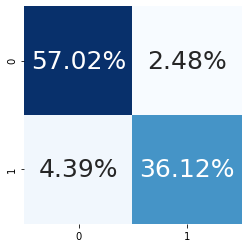

In [ ]:
predict_on_test(model, test_data_iterator, test_data_iterator.n)

## One Cycle Policy 30

### One cycle scheduler

In [ ]:
"""
https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/
"""

class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
def add_noise_rotate(img_array):
    noise = np.random.randint(-5,6, img_array.shape)
    noise = noise 
    img = img_array + noise
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

In [ ]:
train_csv = 'train_labels.csv'
test_csv = 'sample_submission.csv'

traindf=pd.read_csv(train_csv,dtype=str)
testdf=pd.read_csv(test_csv,dtype=str)

def append_ext(fn):
    return fn+".tif"

traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)


train_df,val_df1=train_test_split(traindf,test_size=0.3,random_state=42,stratify=traindf['label'])
val_df,test_df=train_test_split(val_df1,test_size=0.33,random_state=42,stratify=val_df1['label'])

In [ ]:
data_generator = ImageDataGenerator(brightness_range=[0.3, 1], 
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    preprocessing_function=add_noise_rotate)
data_generator_noaug = ImageDataGenerator()

In [ ]:
train_data_iterator=data_generator.flow_from_dataframe(dataframe=train_df,
                                                 directory='train',
                                                 x_col="id",
                                                 y_col="label",
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=False,
                                                 class_mode="binary",
                                                 target_size=IMG_SIZE)

validation_data_iterator=data_generator.flow_from_dataframe(dataframe=val_df,
                                                      directory='train',
                                                      x_col="id",
                                                      y_col="label",
                                                      batch_size=BATCH_SIZE,
                                                      seed=42,
                                                      shuffle=False,
                                                      class_mode="binary",
                                                      target_size=IMG_SIZE)

test_data_iterator = data_generator_noaug.flow_from_dataframe(dataframe=test_df,
                                                         directory='train',
                                                         x_col="id",
                                                         y_col="label",
                                                         batch_size=1,
                                                         seed=42,
                                                         shuffle=False,
                                                         class_mode="binary",
                                                         target_size=IMG_SIZE)

Found 154017 validated image filenames belonging to 2 classes.
Found 44225 validated image filenames belonging to 2 classes.
Found 21783 validated image filenames belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size
STEP_SIZE_test = test_data_iterator.n//test_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281  

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 30

steps = STEP_SIZE_TRAIN * initial_epochs
lr_schedule = OneCycleScheduler(base_learning_rate, steps)

filepath = '{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle_30.h5')
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks_list = [checkpoint, lr_schedule]

In [ ]:
history = model.fit(train_data_iterator, 
                    epochs=initial_epochs, 
                    validation_data=validation_data_iterator,
                    verbose=True,
                    callbacks=callbacks_list)

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle_30.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plot loss and accuracy

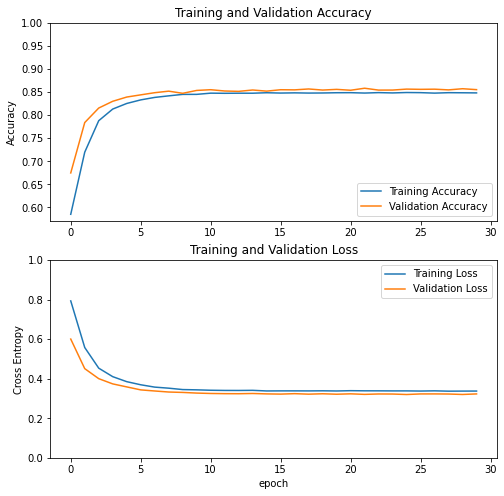

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281  

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs


filepath = '{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle_tuned_30.h5')
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

callbacks_list = [checkpoint, lr_schedule]

In [ ]:
history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=43,#history.epoch[-1], 
                         validation_data=validation_data_iterator, 
                         verbose=True, 
                         callbacks=callbacks_list)

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle_tuned_30.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_onecycle_tuned_30.h5'))

### Confusion Matrix

In [ ]:
# make a prediction
def predict_on_test(model, test_gen, df_size):
    predictions1 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions1, predictions1 >= 0, 1)    
    np.putmask(predictions1, predictions1 < 0, 0)
    
    predictions2 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions2, predictions2 >= 0, 1)
    np.putmask(predictions2, predictions2 < 0, 0)

    predictions3 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions3, predictions3 >= 0, 1)
    np.putmask(predictions3, predictions3 < 0, 0)
    
    predictions4 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions4, predictions4 >= 0, 1)
    np.putmask(predictions4, predictions4 < 0, 0)
    
    predictions5 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions5, predictions5 >= 0, 1)
    np.putmask(predictions5, predictions5 < 0, 0)
    
    predictions = predictions1 + predictions2 + predictions3 + predictions4 + predictions5
    np.putmask(predictions, predictions >= 3, 1)
    np.putmask(predictions, predictions < 3, 0)
    predictions = predictions.flatten()
    df_preds = pd.DataFrame(predictions, columns=['has_tumor_tissue'])

    y_true = test_gen.classes
    y_pred = df_preds['has_tumor_tissue']

    print("F1 Score: " + str(sklearn.metrics.f1_score(y_true, y_pred)))
    print("AUC Score: " + str(sklearn.metrics.roc_auc_score(y_true, y_pred)))
    
    test_labels = test_gen.classes
    cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
    
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score=(2*precision*recall)/(recall+precision)
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 Score: " + str(f1_score))
    print("Accuracy: " + str(accuracy))
    
    sns.heatmap(cm/np.sum(cm), fmt='.2%' , annot=True, cmap='Blues', square=True, cbar=False, annot_kws={'size':25})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


21783/21783 [==============================] - 150s 7ms/step
F1 Score: 0.931366334351409
AUC Score: 0.9406282795177587
Precision: 0.9473622508792497
Recall: 0.9159016207639125
F1 Score: 0.931366334351409
Accuracy: 0.9453243354909792


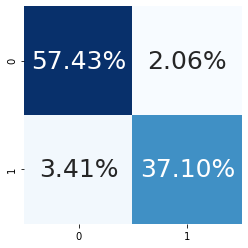

In [ ]:
predict_on_test(model, test_data_iterator, test_data_iterator.n)

## LR Reduction on Plateau 30

### Create data generators

In [ ]:
new_base_dir = 'dataset_folder'
training_sub_path = 'train'
test_sub_path = 'test'

In [ ]:
IMG_SIZE = (96, 96) 
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64

In [ ]:
def add_noise_rotate(img_array):
    noise = np.random.randint(-5,6, img_array.shape)
    noise = noise 
    img = img_array + noise
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

In [ ]:
train_csv = 'train_labels.csv'
test_csv = 'sample_submission.csv'

traindf=pd.read_csv(train_csv,dtype=str)
testdf=pd.read_csv(test_csv,dtype=str)

def append_ext(fn):
    return fn+".tif"

traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)


train_df,val_df1=train_test_split(traindf,test_size=0.3,random_state=42,stratify=traindf['label'])
val_df,test_df=train_test_split(val_df1,test_size=0.33,random_state=42,stratify=val_df1['label'])

In [ ]:
data_generator = ImageDataGenerator(brightness_range=[0.3, 1], 
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    preprocessing_function=add_noise_rotate)
data_generator_noaug = ImageDataGenerator()

In [ ]:
train_data_iterator=data_generator.flow_from_dataframe(dataframe=train_df,
                                                 directory='train',
                                                 x_col="id",
                                                 y_col="label",
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=False,
                                                 class_mode="binary",
                                                 target_size=IMG_SIZE)

validation_data_iterator=data_generator.flow_from_dataframe(dataframe=val_df,
                                                      directory='train',
                                                      x_col="id",
                                                      y_col="label",
                                                      batch_size=BATCH_SIZE,
                                                      seed=42,
                                                      shuffle=False,
                                                      class_mode="binary",
                                                      target_size=IMG_SIZE)

test_data_iterator = data_generator_noaug.flow_from_dataframe(dataframe=test_df,
                                                         directory='train',
                                                         x_col="id",
                                                         y_col="label",
                                                         batch_size=1,
                                                         seed=42,
                                                         shuffle=False,
                                                         class_mode="binary",
                                                         target_size=IMG_SIZE)

Found 154017 validated image filenames belonging to 2 classes.
Found 44225 validated image filenames belonging to 2 classes.
Found 21783 validated image filenames belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_data_iterator.n//train_data_iterator.batch_size
STEP_SIZE_VALIDATION = validation_data_iterator.n//validation_data_iterator.batch_size
STEP_SIZE_test = test_data_iterator.n//test_data_iterator.batch_size

### Create Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_data_iterator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)
#outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

### Train Model

In [ ]:
initial_epochs = 30
filepath = '{}/{}'.format(base_dir, 'mobileNetV2_model_lrreduce_30.h5')
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              

callbacks_list = [checkpoint, reduce_lr]

In [ ]:

history = model.fit(train_data_iterator, 
                    epochs=initial_epochs, 
                    validation_data=validation_data_iterator,
                    verbose=True,
                    callbacks=callbacks_list)

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_lrreduce_30.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Plot loss and accuracy

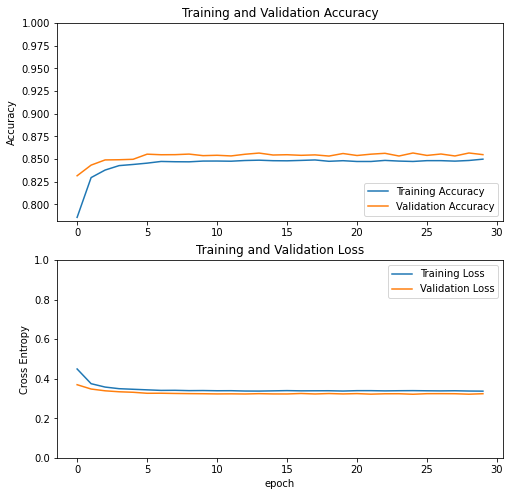

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune model

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281

In [ ]:
len(model.trainable_variables)

56

### Train fine tuned model

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

filepath = '{}/{}'.format(base_dir, 'mobileNetV2_model_lrreduce_tuned_30.h5')
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks_list = [checkpoint, reduce_lr]

In [ ]:
history_fine = model.fit(train_data_iterator, 
                         epochs=total_epochs, 
                         initial_epoch=54,#history.epoch[-1], 
                         validation_data=validation_data_iterator, 
                         verbose=True, 
                         callbacks=callbacks_list)

### Plot improved loss and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

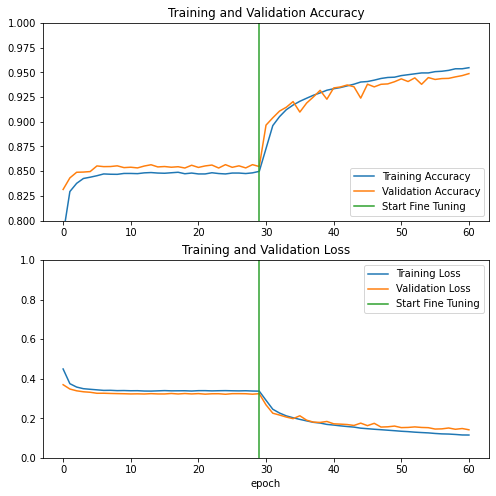

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('{}/{}'.format(base_dir, 'mobileNetV2_model_lrreduce_tuned_30.h5'))

In [ ]:
model = tf.keras.models.load_model('{}/{}'.format(base_dir, 'mobileNetV2_model_lrreduce_tuned_30.h5'))

### Confusion Matrix

In [ ]:
# make a prediction
def predict_on_test(model, test_gen, df_size):
    predictions1 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions1, predictions1 >= 0, 1)    
    np.putmask(predictions1, predictions1 < 0, 0)
    
    predictions2 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions2, predictions2 >= 0, 1)
    np.putmask(predictions2, predictions2 < 0, 0)

    predictions3 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions3, predictions3 >= 0, 1)
    np.putmask(predictions3, predictions3 < 0, 0)
    
    predictions4 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions4, predictions4 >= 0, 1)
    np.putmask(predictions4, predictions4 < 0, 0)
    
    predictions5 = model.predict_generator(test_gen, steps=df_size, verbose=1)
    np.putmask(predictions5, predictions5 >= 0, 1)
    np.putmask(predictions5, predictions5 < 0, 0)
    
    predictions = predictions1 + predictions2 + predictions3 + predictions4 + predictions5
    np.putmask(predictions, predictions >= 3, 1)
    np.putmask(predictions, predictions < 3, 0)
    predictions = predictions.flatten()
    df_preds = pd.DataFrame(predictions, columns=['has_tumor_tissue'])

    y_true = test_gen.classes
    y_pred = df_preds['has_tumor_tissue']

    print("F1 Score: " + str(sklearn.metrics.f1_score(y_true, y_pred)))
    print("AUC Score: " + str(sklearn.metrics.roc_auc_score(y_true, y_pred)))
    
    test_labels = test_gen.classes
    cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
    
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score=(2*precision*recall)/(recall+precision)
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 Score: " + str(f1_score))
    print("Accuracy: " + str(accuracy))
    
    sns.heatmap(cm/np.sum(cm), fmt='.2%' , annot=True, cmap='Blues', square=True, cbar=False, annot_kws={'size':25})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


21783/21783 [==============================] - 151s 7ms/step
F1 Score: 0.9223278726085463
AUC Score: 0.9337198441783049
Precision: 0.9323682686740011
Recall: 0.9125014167516717
F1 Score: 0.9223278726085463
Accuracy: 0.9377496212642886


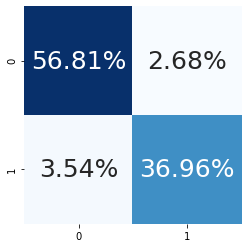

In [ ]:
predict_on_test(model, test_data_iterator, test_data_iterator.n)